<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/SciKitLearn_04_ProjFour_Supervised_Clf_and_Reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libs

In [79]:
!pip install -q import_ipynb

In [80]:
# utils
import os, sys, time, warnings
import import_ipynb
import pandas as pd
import numpy as np
from scipy import stats
# colab
from google.colab import drive
# sklearn
import sklearn
from sklearn import preprocessing, metrics, linear_model, svm
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# vis
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
print(sys.version)
print("sklearn: ", sklearn.__version__)

3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
sklearn:  1.5.2


## Setting

In [82]:
warnings.filterwarnings('ignore')

In [83]:
# mount google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
# working directory
working_dir = '/content/drive/MyDrive/Jupyter Notebooks/'
os.chdir(working_dir)

In [85]:
# load MachineLearningUtils
from MachineLearningUtils import *

In [86]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)

## Dataset

In [87]:
path = 'Inputs/forest_fires/'

In [88]:
df = pd.read_csv(path + 'forestfires.csv', header=0)

In [89]:
summarize_columns(df)

,col_name,dtypes,missing,missing_percent,uniques,first_value,second_value,third_value
0,X,int64,0,0.0,9,7,7,7
1,Y,int64,0,0.0,7,5,4,4
2,month,object,0,0.0,12,mar,oct,oct
3,day,object,0,0.0,7,fri,tue,sat
4,FFMC,float64,0,0.0,106,86.2,90.6,90.6
5,DMC,float64,0,0.0,215,26.2,35.4,43.7
6,DC,float64,0,0.0,219,94.3,669.1,686.9
7,ISI,float64,0,0.0,119,5.1,6.7,6.7
8,temp,float64,0,0.0,192,8.2,18.0,14.6
9,RH,int64,0,0.0,75,51,33,33


In [90]:
reduce_memory_usage(df=df, category=True)

Memory usage of dataframe is 0.051399 MB!
Memory usage after optimization is 0.011193 MB!
Decreased by 78.2%


In [91]:
df['fire_scale'] = df['area'].apply(lambda x: 'no_fire' if (x==0) else 'small_fire' if ((x>0)&(x<2)) else 'large_fire')

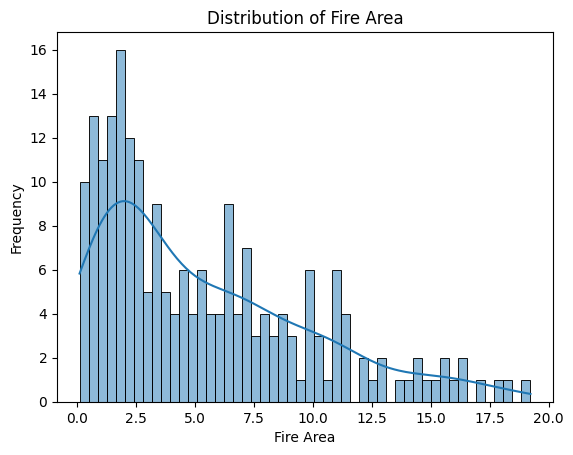

In [92]:
filtered_df = df[(df['area'] > 0) & (df['area'] < 20)]
sns.histplot(filtered_df['area'], bins=50, kde=True)
plt.title('Distribution of Fire Area')
plt.xlabel('Fire Area')
plt.ylabel('Frequency')
plt.show()

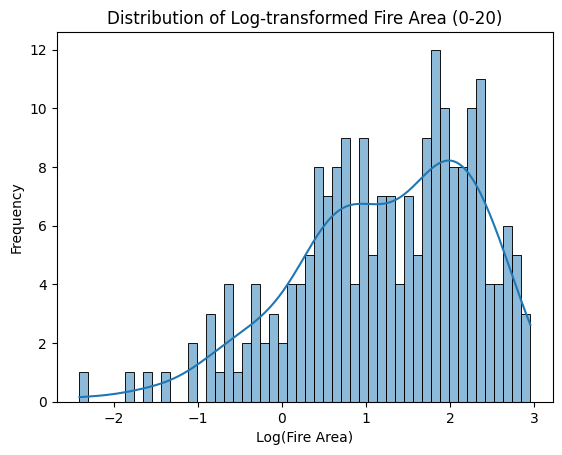

In [93]:
filtered_df = df[(df['area'] > 0) & (df['area'] < 20)]
log_area = np.log(filtered_df['area'])
sns.histplot(log_area, bins=50, kde=True)
plt.title('Distribution of Log-transformed Fire Area (0-20)')
plt.xlabel('Log(Fire Area)')
plt.ylabel('Frequency')
plt.show()

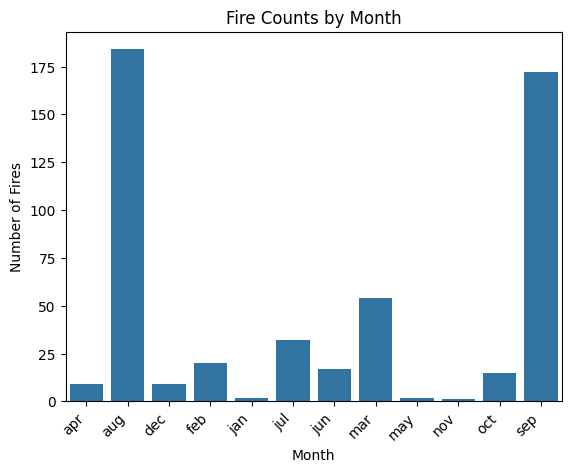

In [94]:
sns.countplot(x='month', data=df)
plt.title('Fire Counts by Month')
plt.xlabel('Month')
plt.ylabel('Number of Fires')
plt.xticks(rotation=45, ha='right')
plt.show()

In [95]:
df.groupby(['month', 'fire_scale'])['fire_scale'].count()

month  fire_scale
apr    large_fire     4
       no_fire        5
       small_fire     0
aug    large_fire    71
       no_fire       85
       small_fire    28
dec    large_fire     9
       no_fire        0
       small_fire     0
feb    large_fire     9
       no_fire       10
       small_fire     1
jan    large_fire     0
       no_fire        2
       small_fire     0
jul    large_fire    12
       no_fire       14
       small_fire     6
jun    large_fire     5
       no_fire        9
       small_fire     3
mar    large_fire    16
       no_fire       35
       small_fire     3
may    large_fire     1
       no_fire        1
       small_fire     0
nov    large_fire     0
       no_fire        1
       small_fire     0
oct    large_fire     5
       no_fire       10
       small_fire     0
sep    large_fire    76
       no_fire       75
       small_fire    21
Name: fire_scale, dtype: int64

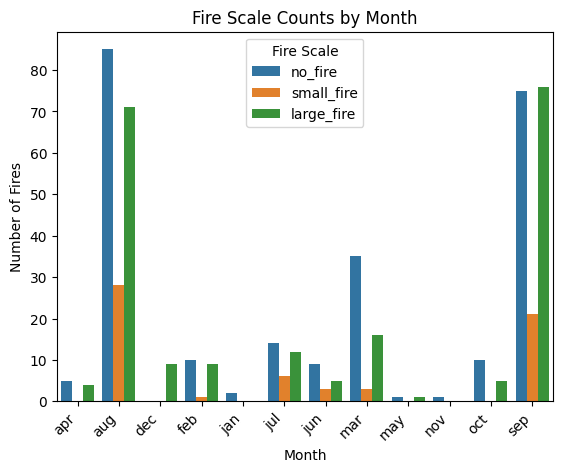

In [96]:
sns.countplot(x='month', hue='fire_scale', data=df)
plt.title('Fire Scale Counts by Month')
plt.xlabel('Month')
plt.ylabel('Number of Fires')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Fire Scale')
plt.show()

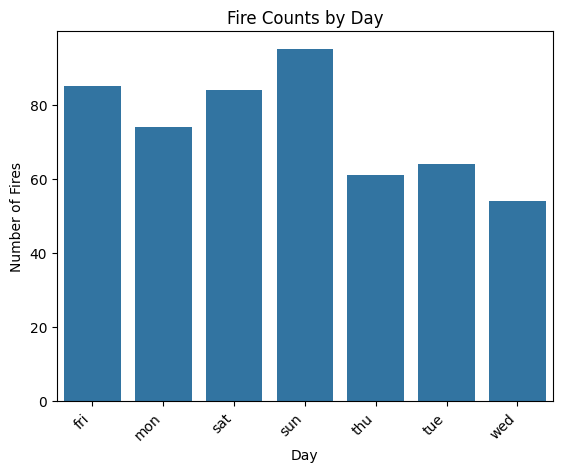

In [97]:
sns.countplot(x='day', data=df)
plt.title('Fire Counts by Day')
plt.xlabel('Day')
plt.ylabel('Number of Fires')
plt.xticks(rotation=45, ha='right')
plt.show()

In [98]:
data = df[df['area'] > 0].copy()
months_to_oversample = data['month'].unique()[~pd.Series(data['month'].unique()).isin(['aug', 'sep'])]

for month in months_to_oversample:
    temp = data[data['month'] == month].sample(300, replace=True)
    data = pd.concat([data, temp], axis=0)

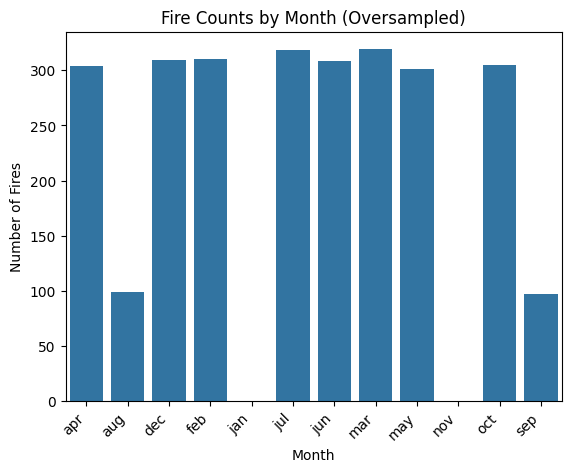

In [99]:
sns.countplot(x='month', data=data)
plt.title('Fire Counts by Month (Oversampled)')
plt.xlabel('Month')
plt.ylabel('Number of Fires')
plt.xticks(rotation=45, ha='right')
plt.show()

In [100]:
X = pd.get_dummies(data, columns=['month', 'day'], drop_first=True)
X = X.drop(['area', 'fire_scale'], axis=1)
y = data['area']

In [101]:
summarize_columns(X)

,col_name,dtypes,missing,missing_percent,uniques,first_value,second_value,third_value
0,X,int8,0,0.0,9,9,1,2
1,Y,int8,0,0.0,7,9,4,5
2,FFMC,float16,0,0.0,84,85.8125,91.0,90.875
3,DMC,float16,0,0.0,148,48.3125,129.5,126.5
4,DC,float16,0,0.0,150,313.5,692.5,686.5
5,ISI,float16,0,0.0,98,3.900391,7.0,7.0
6,temp,float16,0,0.0,144,18.0,21.703125,21.90625
7,RH,int8,0,0.0,60,42,38,39
8,wind,float16,0,0.0,21,2.699219,2.199219,1.799805
9,rain,float16,0,0.0,3,0.0,0.0,0.0


In [102]:
x_train, x_test, y_train, y_test = train_test_split(X, np.log(y+1), shuffle=True)

## Reg Model

In [103]:
def get_numeric_columns(df):
    return df.select_dtypes(include=['float16', 'int8']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', preprocessing.StandardScaler())
    ])

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, get_numeric_columns(x_train))],
    remainder='passthrough'
    )

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

x_train = pipeline.fit_transform(x_train)
x_test = pipeline.transform(x_test)

MSE: 0.7173
MAE: 0.5898
R-squared: 0.4165


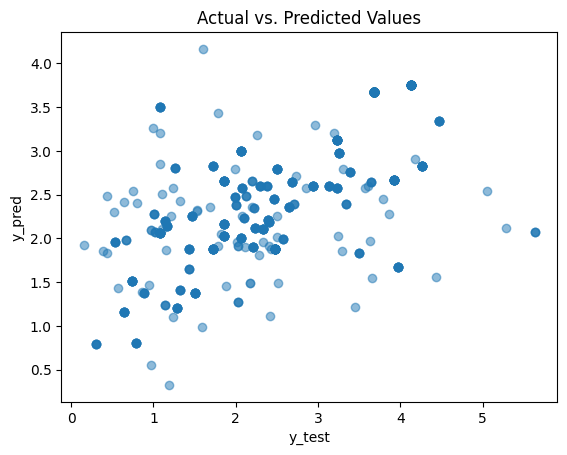

In [104]:
def evaluate_regressor(reg, x_train, y_train, x_test, y_test):
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    mse = metrics.mean_squared_error(y_test, y_pred)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R-squared: {r2:.4f}")

    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.title('Actual vs. Predicted Values')
    plt.show()

reg = linear_model.LinearRegression()
evaluate_regressor(reg, x_train, y_train, x_test, y_test)

MSE: 0.4429
MAE: 0.3637
R-squared: 0.6398


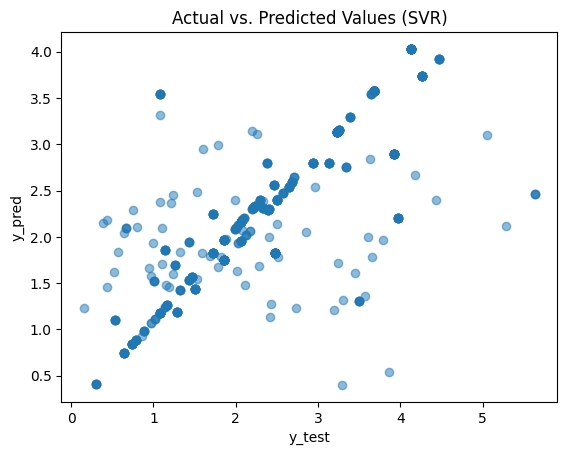

In [105]:
def evaluate_regressor(reg, x_train, y_train, x_test, y_test):
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    mse = metrics.mean_squared_error(y_test, y_pred)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R-squared: {r2:.4f}")

    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.title('Actual vs. Predicted Values (SVR)')
    plt.show()

reg = svm.SVR(C=1, kernel='rbf', gamma='auto', max_iter=int(5e4), cache_size=1000)
evaluate_regressor(reg, x_train, y_train, x_test, y_test)

## Clf Model

In [106]:
dataframe = df.copy()

In [107]:
dataframe.fire_scale.value_counts()

,count
fire_scale,
no_fire,247
large_fire,208
small_fire,62


In [108]:
months_to_oversample = dataframe['month'].unique()[~pd.Series(dataframe['month'].unique()).isin(['aug', 'sep'])]

for month in months_to_oversample:
    temp = dataframe[dataframe['month'] == month].sample(300, replace=True)
    dataframe = pd.concat([dataframe, temp], axis=0)

In [109]:
y = dataframe['fire_scale']
X = pd.get_dummies(dataframe, columns=['month', 'day'], drop_first=True)
X = X.drop(['area', 'fire_scale'], axis=1)
X = X.loc[:, X.var(axis=0) > 0]

In [110]:
corr_matrix = X.corr()

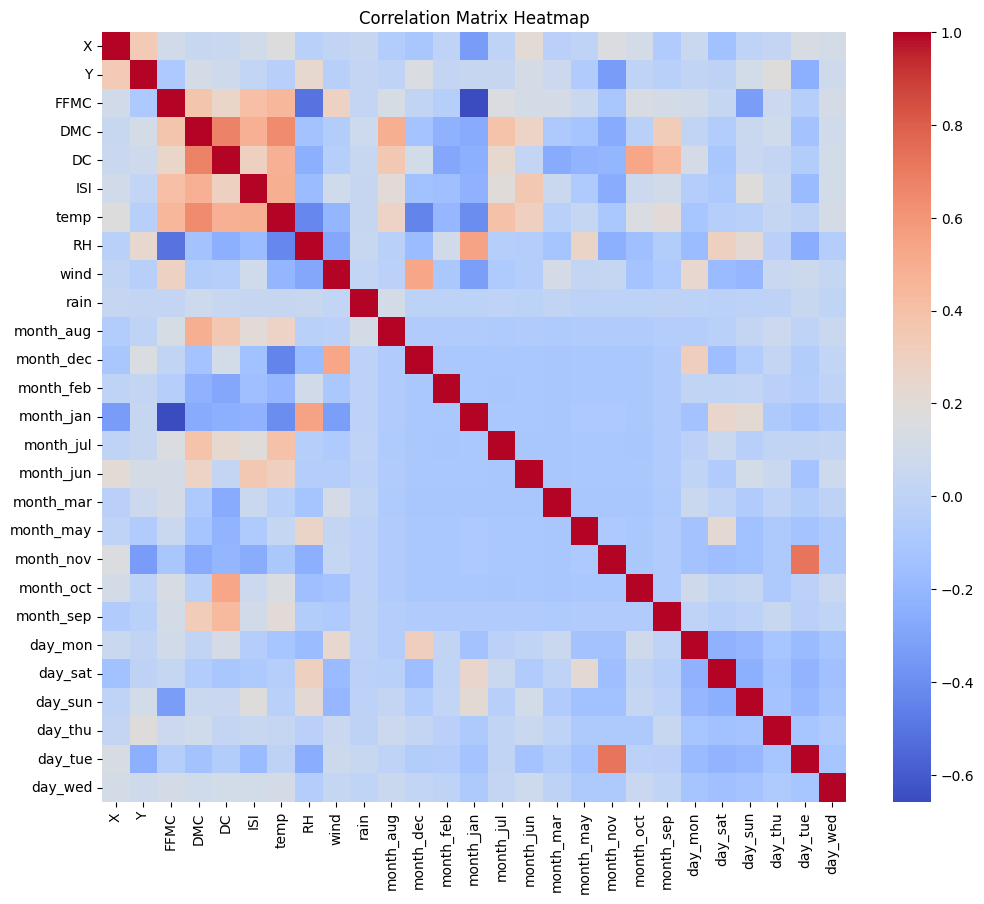

In [111]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [112]:
r_squared_threshold = 0.70
r_squared = corr_matrix ** 2
mask = np.triu(np.ones(r_squared.shape), k=1).astype(bool) # mask the upper triangle (including diagonal) to avoid redundancy
r_squared_triu = r_squared.where(mask)
drop_cols = [col for col in r_squared_triu.columns if any(r_squared_triu[col] > r_squared_threshold)]
X = X.drop(drop_cols, axis=1)
print(f"Columns dropped due to high correlation: {drop_cols}")

Columns dropped due to high correlation: []


In [113]:
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    shuffle=True,
                                                    stratify=y)

In [114]:
def get_numeric_columns(df):
    return df.select_dtypes(include=['float16', 'int8']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', preprocessing.StandardScaler())
    ])

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, get_numeric_columns(x_train))],
    remainder='passthrough'
    )

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

x_train = pipeline.fit_transform(x_train)
x_test = pipeline.transform(x_test)

In [115]:
clf = linear_model.LogisticRegression(max_iter=int(1e7), penalty='elasticnet', solver='saga', l1_ratio=0.75)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
acu = metrics.accuracy_score(y_test, y_pred)
print("acu: ", np.round(acu, 4))
cm = metrics.confusion_matrix(y_test, y_pred)
cm

acu:  0.7648


array([[225,  97,   7],
       [ 58, 430,   6],
       [ 20,  19,  18]])

In [116]:
def evaluate_classifier(clf, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix)

clf = linear_model.LogisticRegression(max_iter=int(1e7), penalty='elasticnet', solver='saga', l1_ratio=0.75)
evaluate_classifier(clf, x_train, y_train, x_test, y_test)

Accuracy: 0.7648
Confusion Matrix:
[[225  97   7]
 [ 58 430   6]
 [ 20  19  18]]


In [117]:
def evaluate_classifier(clf, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix)

clf = svm.SVC(C=1, kernel='rbf', gamma='auto', max_iter=int(5e4), cache_size=1000)
evaluate_classifier(clf, x_train, y_train, x_test, y_test)

Accuracy: 0.8273
Confusion Matrix:
[[269  60   0]
 [ 46 448   0]
 [ 22  24  11]]
